# Redes neuronales profundas
## Global
- Carlos Moreno: 47840
- Lautaro Fernandez: 48534

### Imports

In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


## Dataset

### Normalizacion
Obtener media y desviacion estandar para normalizar

In [2]:
def get_mean_and_std(img_dir):
    img_list = os.listdir(img_dir + '/day_train/')
    mean = 0.0
    std = 0.0
    for img_name in img_list:
        img_tensor = read_image(img_dir + '/day_train/' + img_name)
        img_tensor = img_tensor.float()[:3]
        mean += img_tensor.mean(dim=(1,2))
        std += img_tensor.std(dim=(1,2))
    mean /= len(img_list)
    std /= len(img_list)
    return mean, std

In [3]:
mean, std = get_mean_and_std('data_carla')

### Dataset

In [33]:
class CarlaDataSet(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, train=True):
        self.day_folder = img_dir + '/day_train/' if train else img_dir + '/day_val/'
        self.night_folder = img_dir + '/night_train/' if train else img_dir + '/night_val/'
        self.img_labels = self.build_data_table()
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def build_data_table(self):
        data_table = pd.DataFrame(columns=['image', 'target'])
        data_table['image'] = [self.day_folder+img for img in os.listdir(self.day_folder) ]
        data_table['target'] = [self.night_folder+img for img in os.listdir(self.night_folder) ]
        return data_table
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        lbl_path = self.img_labels.iloc[idx, 1]
        # generates 4 channels because the image is in RGBA format (png)
        image = read_image(img_path)[:3]
        label = read_image(lbl_path)[:3]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



In [46]:
SIZE_IMAGES = (256, 256)

transformations = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=.1),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean, std)
])

def get_datasets(img_dir):
  return (CarlaDataSet(img_dir, transform=transformations, target_transform=transforms.Resize(SIZE_IMAGES), train=True), 
          CarlaDataSet(img_dir, transform=transformations, target_transform=transforms.Resize(SIZE_IMAGES), train=False))

def get_data_iters(dataset_train, dataset_test):
  return DataLoader(dataset_train, batch_size=32, shuffle=True), DataLoader(dataset_test, batch_size=32, shuffle=True)

### Muestreo

In [47]:
def show_sample(dataset:CarlaDataSet,sample: int):
  img = Image.open(dataset.img_labels.iloc[sample, 0])
  target = Image.open(dataset.img_labels.iloc[sample, 1])

  print('sample: ', sample)

  _, axes = plt.subplots(1, 2)

  axes[0].imshow(img)
  axes[0].set_title('Image')
  axes[1].imshow(target)
  axes[1].set_title('Target')

  for ax in axes:
    ax.axis('off')

  plt.show()

In [48]:
dataset_train, dataset_val = get_datasets('data_carla')
data_train, data_val = get_data_iters(dataset_train, dataset_val)

sample:  365


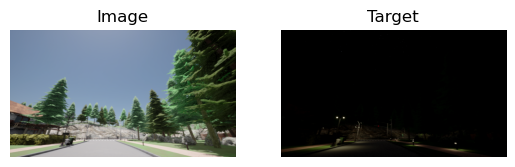

In [49]:
sample = random.randint(0, len(dataset_train))
show_sample(dataset_train,sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


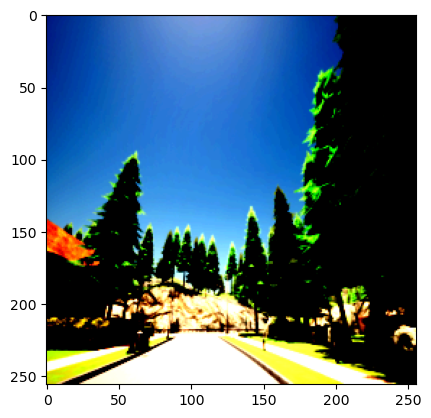

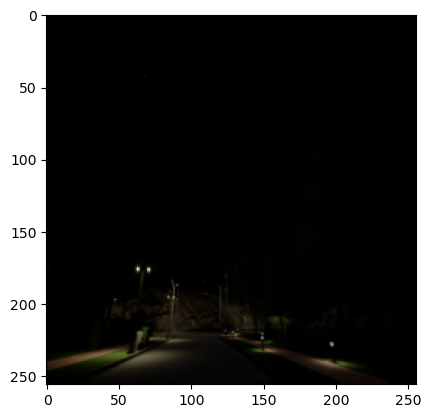

torch.Size([3, 256, 256])
tensor(-2.7375) tensor(2.5227)


In [50]:
# code to show a rgb image of the dataset using dataset_train[sample]

def plot_tensor(tensor: torch.Tensor):
  tensor = tensor.permute(1, 2, 0)
  plt.imshow(tensor)
  plt.show()
  
plot_tensor(dataset_train[sample][0])
plot_tensor(dataset_train[sample][1])
print(dataset_train[sample][0].shape)
print(dataset_train[sample][0].min(), dataset_train[sample][0].max())

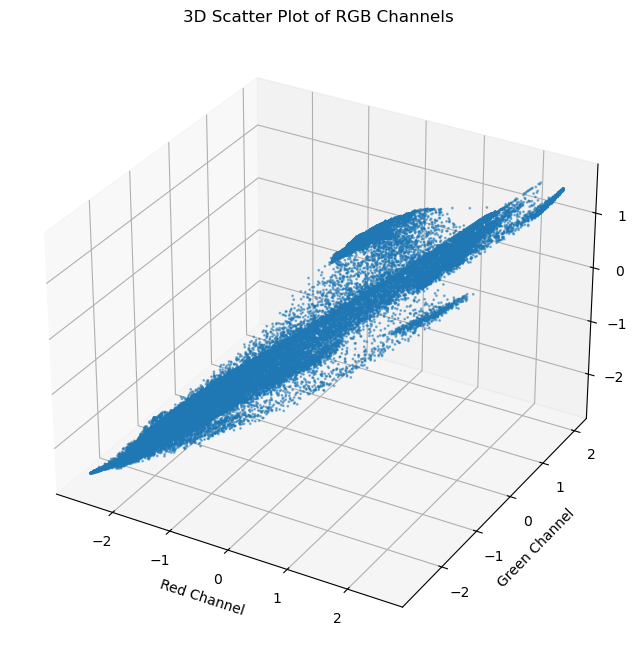

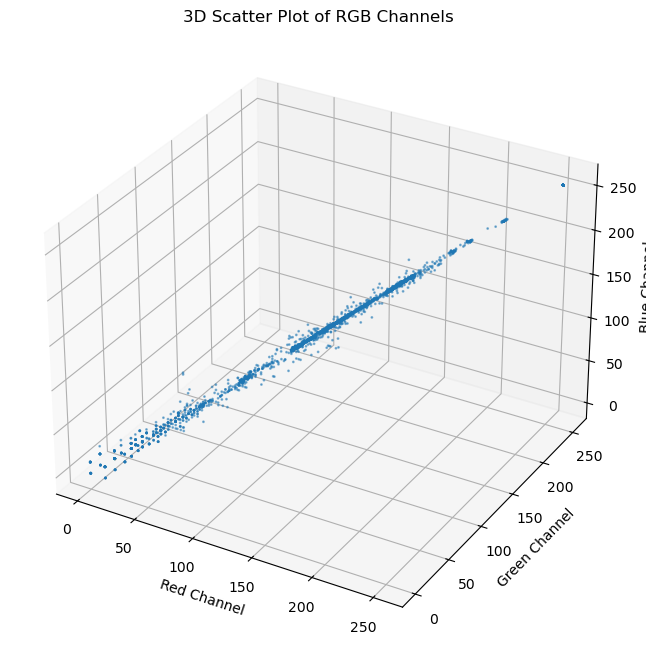

In [51]:
def scatter_plot_three_channels(rgb_image):
    """
    Create a 3D scatter plot of the RGB channels of an image.

    Parameters:
    - rgb_image: A tensor or NumPy array of shape (C, H, W) or (H, W, C).
    """

    if isinstance(rgb_image, torch.Tensor):
        rgb_image = rgb_image.numpy()
        if rgb_image.shape[0] == 3:  
            rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Convert to (H, W, C)

    # Flatten the channels
    r_values = rgb_image[..., 0].flatten()  # Red channel
    g_values = rgb_image[..., 1].flatten()  # Green channel
    b_values = rgb_image[..., 2].flatten()  # Blue channel

    # Create 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(r_values, g_values, b_values, alpha=0.5, s=1)  # Set size of points to 1 for clarity

    ax.set_title('3D Scatter Plot of RGB Channels')
    ax.set_xlabel('Red Channel')
    ax.set_ylabel('Green Channel')
    ax.set_zlabel('Blue Channel')
    
    plt.show()

# Example usage
scatter_plot_three_channels(dataset_train[sample][0])
scatter_plot_three_channels(read_image(dataset_train.img_labels.iloc[sample, 0]))
